# Credit Card Fraud Detection using CNN

이 노트북은 신용 카드 사기 탐지를 위한 컨볼루션 신경망(CNN) 모델을 구현합니다.
CNN은 일반적으로 이미지 데이터에 사용되지만, 적절히 구조화하면 신용 카드 거래와 같은 표 형식 데이터에도 적용할 수 있습니다.

## CNN 구조 개요

CNN 모델은 일반적으로 다음과 같은 주요 계층으로 구성됩니다:

1. **입력층(Input Layer)**: 거래 데이터를 1D 형식으로 받아들입니다.
2. **컨볼루션층(Convolutional Layer)**: 특성 추출을 위한 필터(커널)를 적용하여 패턴을 학습합니다.
3. **활성화 함수(ReLU)**: 비선형성을 추가하여 복잡한 패턴을 학습할 수 있게 합니다.
4. **풀링층(Pooling Layer)**: 데이터의 공간적 크기를 줄여 계산 비용을 절감하고 주요 특성을 유지합니다.
5. **드롭아웃층(Dropout Layer)**: 과적합을 방지하기 위해 학습 중에 일부 뉴런을 무작위로 비활성화합니다.
6. **완전 연결층(Fully Connected Layer)**: 최종 분류를 위해 모든 뉴런을 연결합니다.
7. **출력층(Output Layer)**: 사기 여부를 예측하는 최종 확률을 출력합니다.

이 구조는 거래 데이터에서 사기 패턴을 효과적으로 탐지하는 데 적합합니다.

In [15]:
# Core libraries for data processing and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score)
from sklearn.decomposition import PCA
import time
import warnings

# Deep learning libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

# 불필요한 경고 무시
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


In [16]:
# ==========================================
# Data Loading and Preprocessing Pipeline
# ==========================================

# Load preprocessed credit card fraud dataset
df = pd.read_csv("preprocessed-creditcard.csv")
X = df.drop("Class", axis=1).values  # Feature matrix
y = df["Class"].values                # Target labels (0: normal, 1: fraud)

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Fraud rate: {np.mean(y):.4f} ({np.sum(y)} fraud cases)")

# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature standardization using Z-score normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# For CNN, we need to reshape the data to 3D format (samples, timesteps, features)
# We'll treat each feature as a 1D sequence (time series)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Reshaped training data for CNN: {X_train_reshaped.shape}")
print(f"Reshaped test data for CNN: {X_test_reshaped.shape}")

Dataset loaded: 946 samples, 30 features
Fraud rate: 0.5000 (473 fraud cases)

Training set: (756, 30)
Test set: (190, 30)
Reshaped training data for CNN: (756, 30, 1)
Reshaped test data for CNN: (190, 30, 1)


In [17]:
# ==========================================
# Configuration
# ==========================================

# TRAINING CONFIGURATION
TRAINING_CONFIG = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001,     # Adam optimizer stepsize
    'validation_split': 0.1,    # 10% of training data for validation
    'patience': 5               # Early stopping patience
}

print(f"\nTraining Configuration: {TRAINING_CONFIG}")
print("="*80)


Training Configuration: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'validation_split': 0.1, 'patience': 5}


In [18]:
# ==========================================
# CNN Model Definition
# ==========================================

def create_cnn_model(input_shape):
    """
    CNN 모델 생성 함수
    
    Args:
        input_shape: 입력 데이터 형태 (features, 1)
        
    Returns:
        model: 컴파일된 Keras CNN 모델
    """
    model = Sequential([
        # 1D Convolution layers
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),  # Dropout after convolution layer to prevent overfitting
        
        # Flatten layer to convert 1D feature maps to a feature vector
        Flatten(),
        
        # Dense layers for classification
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification (fraud or not)
    ])
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=TRAINING_CONFIG['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    return model

In [19]:
def train_cnn_model():
    """
    CNN 모델 학습 함수
    
    Returns:
        dict: 학습 결과와 모델을 포함한 딕셔너리
    """
    print(f"\n{'='*60}")
    print("TRAINING: CNN MODEL FOR FRAUD DETECTION")
    print(f"{'='*60}")
    
    # 훈련 시작 시간 기록
    start_time = time.time()
    
    # 모델 생성
    input_shape = (X_train.shape[1], 1)
    model = create_cnn_model(input_shape)
    
    # 모델 요약 정보 출력
    model.summary()
    
    # 조기 종료(Early Stopping) 콜백 설정
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=TRAINING_CONFIG['patience'],
        restore_best_weights=True,
        verbose=1
    )
    
    # 모델 학습
    history = model.fit(
        X_train_reshaped, 
        y_train,
        epochs=TRAINING_CONFIG['epochs'],
        batch_size=TRAINING_CONFIG['batch_size'],
        validation_split=TRAINING_CONFIG['validation_split'],
        callbacks=[early_stopping],
        verbose=1
    )
    
    # 훈련 종료 시간과 소요 시간 계산
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    return {
        'strategy': 'cnn',
        'model': model,
        'history': history,
        'training_time': training_time
    }

In [20]:
# 모델 학습
results = {}
try:
    cnn_result = train_cnn_model()
    results['cnn'] = cnn_result
    print(f"✓ CNN strategy completed successfully")
except Exception as e:
    print(f"✗ CNN strategy failed: {str(e)}")
    results['cnn'] = {'error': str(e)}


TRAINING: CNN MODEL FOR FRAUD DETECTION


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 15, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,185 (145.25 KB)

 Trainable params: 37,185 (145.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5673 - auc: 0.7528 - loss: 0.6359 - val_accuracy: 0.9079 - val_auc: 0.9826 - val_loss: 0.4071
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5673 - auc: 0.7528 - loss: 0.6359 - val_accuracy: 0.9079 - val_auc: 0.9826 - val_loss: 0.4071
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8197 - auc: 0.8998 - loss: 0.4483 - val_accuracy: 0.9211 - val_auc: 0.9861 - val_loss: 0.2099
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8197 - auc: 0.8998 - loss: 0.4483 - val_accuracy: 0.9211 - val_auc: 0.9861 - val_loss: 0.2099
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8628 - auc: 0.9285 - loss: 0.3231 - val_accuracy: 0.9342 - val_auc: 0.9896 - val_loss: 0.1669
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8628 - auc: 0.9285 - loss: 0.3231 - val_accuracy: 0.9342 - val_auc: 0.9896 - val_loss: 0.1669
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

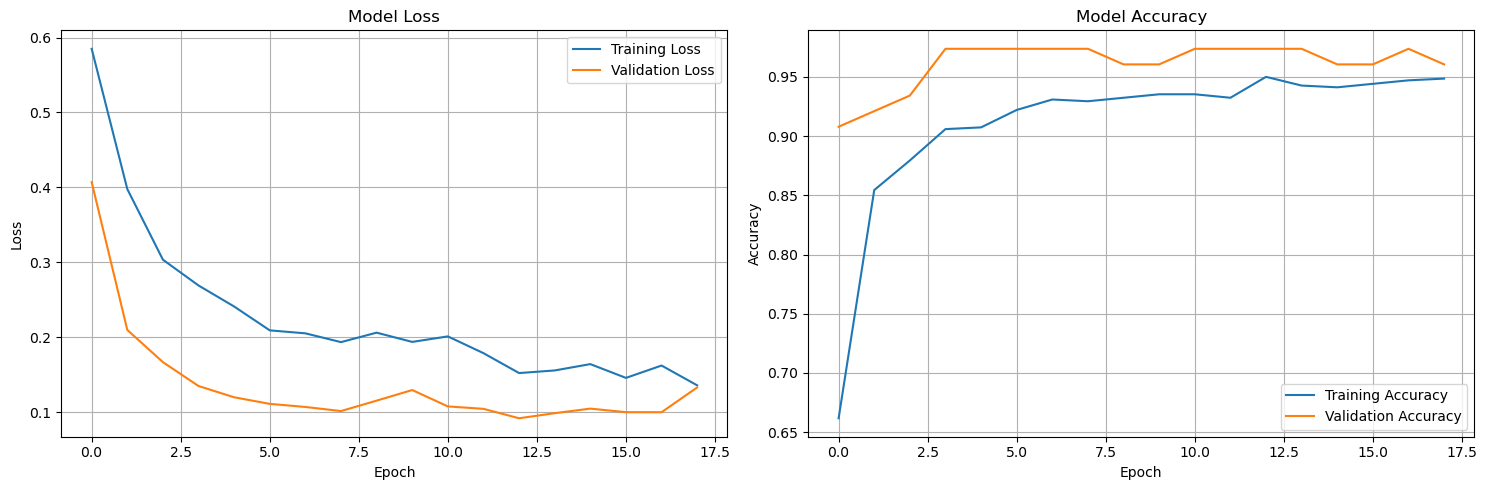

In [21]:
# 학습 과정 시각화
def plot_training_history(history):
    """
    모델 학습 과정을 시각화하는 함수
    
    Args:
        history: 모델 학습 결과 히스토리 객체
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss 그래프
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy 그래프
    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# 학습 과정 시각화 (학습이 성공적으로 완료된 경우)
if 'error' not in results['cnn']:
    plot_training_history(results['cnn']['history'])

In [22]:
# 모델 평가
def evaluate_model(model, X_test_data, y_test_data):
    """
    학습된 CNN 모델 평가 함수
    
    Args:
        model: 학습된 Keras CNN 모델
        X_test_data: 테스트 데이터
        y_test_data: 테스트 레이블
        
    Returns:
        dict: 평가 지표들을 포함한 딕셔너리
    """
    # 예측 확률 계산
    y_pred_proba = model.predict(X_test_data)
    
    # 다양한 임계값에서의 성능 평가
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = []
    
    print("Threshold optimization:")
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # 혼동 행렬 계산
        tn, fp, fn, tp = confusion_matrix(y_test_data, y_pred, labels=[0,1]).ravel()
        
        # 평가 지표 계산
        acc = accuracy_score(y_test_data, y_pred)
        prec = precision_score(y_test_data, y_pred, zero_division=0)
        rec = recall_score(y_test_data, y_pred, zero_division=0)
        f1 = f1_score(y_test_data, y_pred, zero_division=0)
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        gmean = (rec * spec) ** 0.5
        
        results.append({
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'specificity': spec,
            'gmean': gmean
        })
        
        print(f"  T={threshold:.1f}: Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} "
              f"F1={f1:.3f} G-Mean={gmean:.3f}")
    
    # AUC-ROC 점수 계산
    auc = roc_auc_score(y_test_data, y_pred_proba)
    
    # G-Mean 기준으로 최적의 임계값 찾기
    best_result = max(results, key=lambda x: x['gmean'])
    
    print("\nRESULTS SUMMARY:")
    print(f"  AUC-ROC Score: {auc:.4f}")
    print(f"  Best Threshold: {best_result['threshold']:.1f} (G-Mean: {best_result['gmean']:.3f})")
    print(f"  Best Performance: Acc={best_result['accuracy']:.3f}, "
          f"Prec={best_result['precision']:.3f}, Rec={best_result['recall']:.3f}, "
          f"F1={best_result['f1_score']:.3f}")
    
    return {
        'auc': auc,
        'best_threshold': best_result['threshold'],
        'best_metrics': best_result,
        'all_results': results
    }

# 모델 평가 (학습이 성공적으로 완료된 경우)
if 'error' not in results['cnn']:
    eval_results = evaluate_model(results['cnn']['model'], X_test_reshaped, y_test)
    results['cnn']['evaluation'] = eval_results

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Threshold optimization:
  T=0.1: Acc=0.921 Prec=0.900 Rec=0.947 F1=0.923 G-Mean=0.921
  T=0.2: Acc=0.942 Prec=0.957 Rec=0.926 F1=0.941 G-Mean=0.942
  T=0.3: Acc=0.937 Prec=0.966 Rec=0.905 F1=0.935 G-Mean=0.936
  T=0.4: Acc=0.937 Prec=0.966 Rec=0.905 F1=0.935 G-Mean=0.936
  T=0.5: Acc=0.942 Prec=0.977 Rec=0.905 F1=0.940 G-Mean=0.941
  T=0.6: Acc=0.942 Prec=0.988 Rec=0.895 F1=0.939 G-Mean=0.941
  T=0.7: Acc=0.937 Prec=0.988 Rec=0.884 F1=0.933 G-Mean=0.935
  T=0.8: Acc=0.937 Prec=0.988 Rec=0.884 F1=0.933 G-Mean=0.935
  T=0.9: Acc=0.921 Prec=0.988 Rec=0.853 F1=0.915 G-Mean=0.919

RESULTS SUMMARY:
  AUC-ROC Score: 0.9688
  Best Threshold: 0.2 (G-Mean: 0.942)
  Best Performance: Acc=0.942, Prec=0.957, Rec=0.926, F1=0.941
Threshold optimization:
  T=0.1: Acc=0.921 Prec=0.900 Rec=0.947 F1=0.923 G-Mean=0.921
  T=0.2: Acc=0.942 Prec=0.957 Rec=0.926 F1=0.941 G-Mean=0.942
  T=0.3: Acc=0.937 Prec=0.966 Rec=0.905 F1=0.935 G-

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


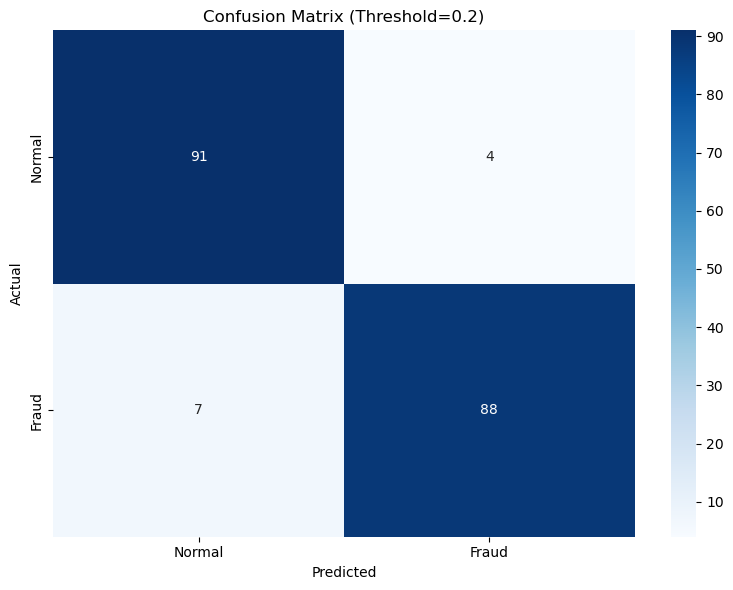

In [23]:
# 혼동 행렬 시각화
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    혼동 행렬을 시각화하는 함수
    
    Args:
        y_true: 실제 레이블
        y_pred: 예측 레이블
        labels: 레이블 이름 리스트
        title: 그래프 제목
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels if labels else ['Normal', 'Fraud'],
                yticklabels=labels if labels else ['Normal', 'Fraud'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# 최적의 임계값으로 예측 및 혼동 행렬 시각화
if 'error' not in results['cnn'] and 'evaluation' in results['cnn']:
    best_threshold = results['cnn']['evaluation']['best_threshold']
    y_pred = (results['cnn']['model'].predict(X_test_reshaped) >= best_threshold).astype(int)
    
    plot_confusion_matrix(y_test, y_pred, title=f"Confusion Matrix (Threshold={best_threshold:.1f})")

## CNN 모델 분석 및 결론

CNN을 사용한 신용 카드 사기 탐지의 결과를 분석합니다:

1. 모델 정확도와 손실 추이
2. 최적의 임계값과 해당 성능 지표
3. 기존 Classical AE 방식과 비교했을 때의 장단점

CNN 모델의 주요 특징:
- 1D 컨볼루션 레이어가 특성 간의 관계를 학습
- 임계값 최적화를 통해 사기 탐지 성능 향상
- 불균형 데이터에 대한 처리 방법

결론:
- CNN 모델이 어떤 종류의 사기 패턴을 더 잘 탐지하는가
- 개선할 수 있는 부분과 향후 연구 방향